**Universidad de Los Andes - Facultad de Economía** <br>
**Machine Learning para Business Intelligence** <br>
**_Paula Rodríguez, Juan S. Moreno, Mateo Dulce_**
# Clase 6: Series de Tiempo

**Lo que cubriremos esta clase:**
1. Introducción: Definiciones y métricas de calidad
2. Mover, suavizar y evaluar series de tiempo
3. Pronósticos:
    - Validación cruzada para series de tiempo
    - Modelos con enfoque econométrico
    - Modelos con enfoque de aprendizaje de máquinas

**Recursos adicionales:**
- Recurso teórico: [_Statistical forecasting: notes on regression and time series analysis, Robert Nau_](https://people.duke.edu/~rnau/411home.htm)
- Recurso práctico (programación): [Time Series Analysis (TSA) in Python - Linear Models to GARCH](http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016)

## 1. Introducción: Definiciones y métricas de calidad

**_Una serie de tiempo es una serie de puntos de datos indexados (o listados, o graficados) en orden de tiempo._**

Importemos algunas librerías. Primero, necesitaremos la librería [statsmodels] (http://statsmodels.sourceforge.net/stable/), que tiene muchas funciones de modelación estadística, incluidas series de tiempo.

In [1]:
import numpy as np                               # vectores y matrices
import pandas as pd                              # tablas y manipulacion de datos
import matplotlib.pyplot as plt                  # graficos
import seaborn as sns                            # más graficos
sns.set()

from dateutil.relativedelta import relativedelta # manejo de fechas
from scipy.optimize import minimize              # para minimizar funciones

import statsmodels.formula.api as smf            # estadictica y econometria
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # alguna funciones utiles
from tqdm import tqdm_notebook

import warnings                                  # modo `no molestar`
warnings.filterwarnings('ignore')

%matplotlib inline

Como ejemplo, miremos datos reales de juegos móviles. Específicamente, analizaremos los anuncios vistos por hora y el gasto de dinero en el juego por día:

In [3]:
ads = pd.read_csv('./data/ads.csv', index_col=['Time'], parse_dates=['Time'])
currency = pd.read_csv('./data/currency.csv', index_col=['Time'], parse_dates=['Time'])

In [9]:
ads.head(25)

,Ads
Time,
2017-09-13 00:00:00,80115
2017-09-13 01:00:00,79885
2017-09-13 02:00:00,89325
2017-09-13 03:00:00,101930
2017-09-13 04:00:00,121630
2017-09-13 05:00:00,116475
2017-09-13 06:00:00,106495
2017-09-13 07:00:00,102795
2017-09-13 08:00:00,108055


In [5]:
currency.head()

,GEMS_GEMS_SPENT
Time,
2017-05-01,1199436
2017-05-02,1045515
2017-05-03,586111
2017-05-04,856601
2017-05-05,793775


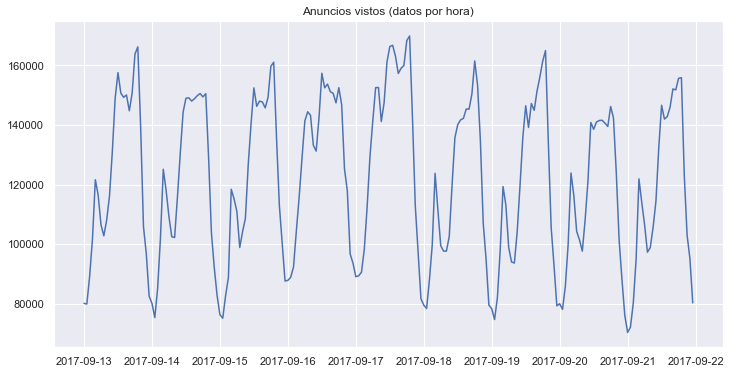

In [6]:
# grafiquemos la serie de tiempo de anuncios
plt.figure(figsize=(12, 6))
plt.plot(ads.Ads)
plt.title('Anuncios vistos (datos por hora)')
plt.grid(True)
plt.show()

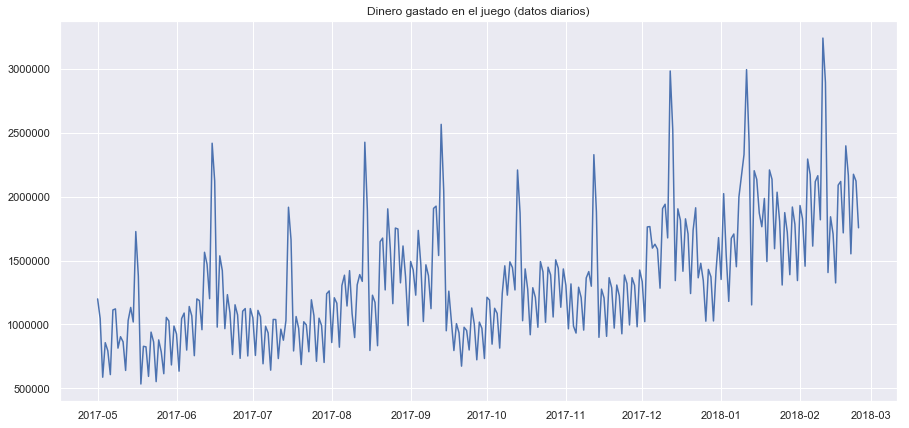

In [10]:
# grafiquemos la serie de tiempo de gastos diarios en juegos 

plt.figure(figsize=(15, 7))
plt.plot(currency.GEMS_GEMS_SPENT)
plt.title('Dinero gastado en el juego (datos diarios)')
plt.grid(True)
plt.show()

### Métricas para pronósticos

Antes de comenzar a pronosticar, veamos cómo medir la calidad de nuestras predicciones.

- [R squared](http://scikit-learn.org/stable/modules/model_evaluation.html#r2-score-the-coefficient-of-determination): coeficiente de determinación (en econometría, esto puede interpretarse como el porcentaje de varianza explicado por el modelo), $(-\infty, 1]$

$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$ 

```python
sklearn.metrics.r2_score
```
---
- [Mean Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-error): esta es una métrica interpretable porque tiene la misma unidad de medida que la serie inicial, $[0, +\infty)$

$MAE = \frac{\sum\limits_{i=1}^{n} |y_i - \hat{y}_i|}{n}$ 

```python
sklearn.metrics.mean_absolute_error
```
---
- [Median Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#median-absolute-error): nuevamente, una métrica interpretable que es particularmente interesante porque es robusta para los valores atípicos, $[0, +\infty)$

$MedAE = median(|y_1 - \hat{y}_1|, ... , |y_n - \hat{y}_n|)$

```python
sklearn.metrics.median_absolute_error
```
---
- [Mean Squared Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error): la métrica más utilizada que otorga una penalización más alta a los errores grandes y viceversa, $[0, +\infty)$

$MSE = \frac{1}{n}\sum\limits_{i=1}^{n} (y_i - \hat{y}_i)^2$

```python
sklearn.metrics.mean_squared_error
```
---
- [Mean Squared Logarithmic Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-logarithmic-error): prácticamente, esto es lo mismo que MSE, pero tomamos el logaritmo de la serie. Como resultado, también damos más peso a los pequeños errores. Esto generalmente se usa cuando los datos tienen tendencias exponenciales, $[0, +\infty)$

$MSLE = \frac{1}{n}\sum\limits_{i=1}^{n} (log(1+y_i) - log(1+\hat{y}_i))^2$

```python
sklearn.metrics.mean_squared_log_error
```
---
- Mean Absolute Percentage Error: Esto es lo mismo que MAE, pero se calcula como un porcentaje. $[0, +\infty)$

$MAPE = \frac{100}{n}\sum\limits_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{y_i}$ 

```python
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
```

## 2. Mover, suavizar y evaluar series de tiempo

Comencemos con la idea de que "mañana será lo mismo que hoy". Sin embargo, en lugar de un modelo como $ \hat {y} _ {t} = y_ {t-1} $, asumiremos que el valor futuro de nuestra variable depende del promedio de sus valores anteriores de $ k $. Por lo tanto, utilizaremos el **promedio móvil**.

In [16]:
# utilizando un promedio movil de 24 horas, cuántos anuncios se verán en 2017-09-22 00:00:00?
n = 24
promedio_movil = np.average(ads[-n:])
promedio_movil

116805.0

Desafortunadamente, no podemos hacer predicciones en el futuro: para obtener el valor para el siguiente paso, necesitamos que se observen los valores anteriores. Pero la media móvil tiene otro caso de uso: **suavizar la serie de tiempo original para identificar tendencias**. </br>

Pandas tiene una implementación disponible con [`DataFrame.rolling (window) .mean ()`] (http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rolling.html). Cuanto más ancha es la ventana, más suave es la tendencia. En el caso de datos muy ruidosos este procedimiento puede ayudar a detectar patrones.

In [21]:
# usar .rolling para obtener promedio en ventana de 12 horas
ads.rolling(window=12).mean()

,Ads
Time,
2017-09-13 00:00:00,NaN
2017-09-13 01:00:00,NaN
2017-09-13 02:00:00,NaN
2017-09-13 03:00:00,NaN
2017-09-13 04:00:00,NaN
2017-09-13 05:00:00,NaN
2017-09-13 06:00:00,NaN
2017-09-13 07:00:00,NaN
2017-09-13 08:00:00,NaN


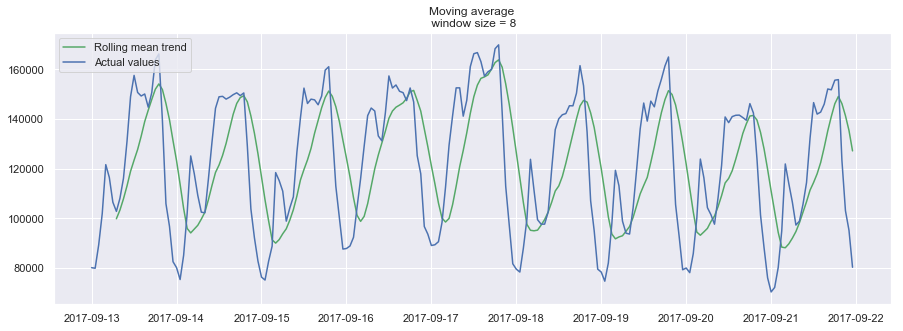

In [25]:
# grafiquemos la serie de tiempo obtenida por promedio movil de 8 horas y la serie de tiempo original
window = 8
rolling_mean = ads.rolling(window=window).mean()

plt.figure(figsize=(15,5))
plt.title("Moving average\n window size = {}".format(window))
plt.plot(rolling_mean, "g", label="Rolling mean trend")

plt.plot(ads, label="Actual values")
plt.legend(loc="upper left")
plt.grid(True)

In [29]:
# definamos una funcion para graficar y poder cambiar la vetana de tiempo
# grafiquemos también los intervalos de confianza para la suavizavión por promedio movil

from sklearn.metrics import mean_absolute_error

def grafPromedioMovil(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # grafcicar intrvalo de confianza
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # graficar outliers (puntos que estén fuera del intervalo de confianza)
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

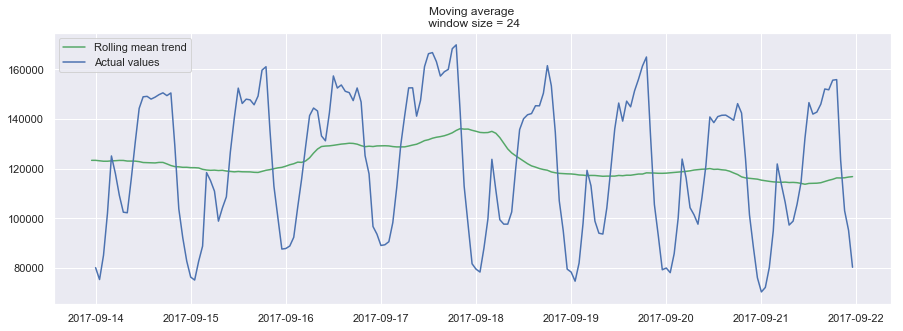

In [27]:
# veamos las tendencias diarias
grafPromedioMovil(ads, 24)

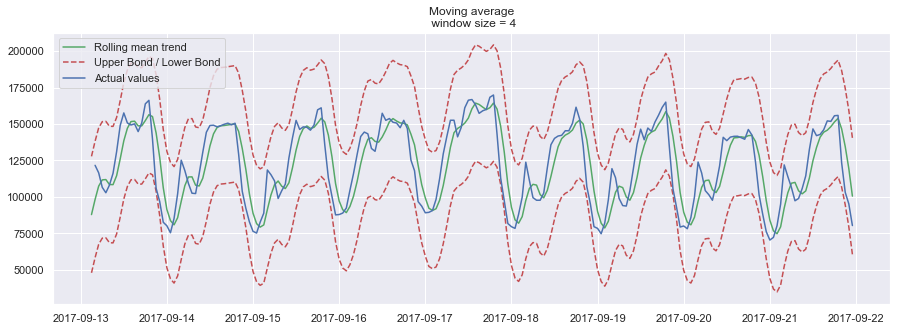

In [30]:
grafPromedioMovil(ads, 4, plot_intervals=True)

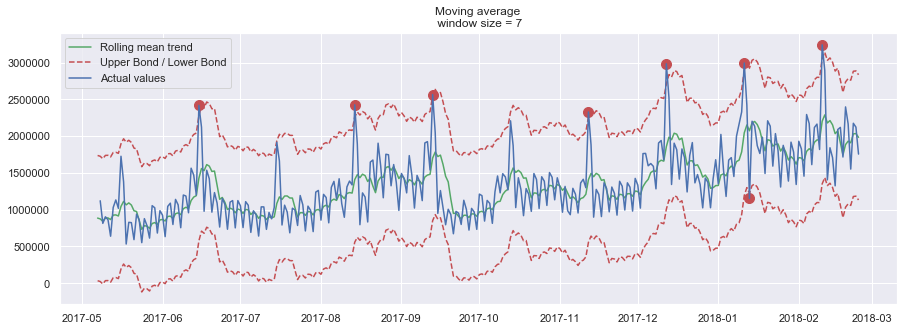

In [32]:
# veamos la tendencia semanal del gasto en los juegos
grafPromedioMovil(currency, 7, plot_intervals=True, plot_anomalies=True)

**no capturó la estacionalidad mensual en nuestros datos y marcó casi todos los picos de 30 días como anomalías!!**

- **Promedio ponderado:** $\hat{y}_{t} = \displaystyle\sum^{k}_{n=1} \omega_n y_{t+1-n}$
</br>
</br>
- **Suavizamiento exponencial:** $\hat{y}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t-1} \quad ; \quad \hat y_{0} = y_{0} $

In [46]:
# realizar una suavizacion exponencial con alpha = 0.1
alpha = 0.1
result = [ads.Ads[0]] #el primer valor es el mismo que el de la serie
for n in range(1, len(ads.Ads)):
    result.append(alpha * ads.Ads[n] + (1 - alpha) * result[n-1])

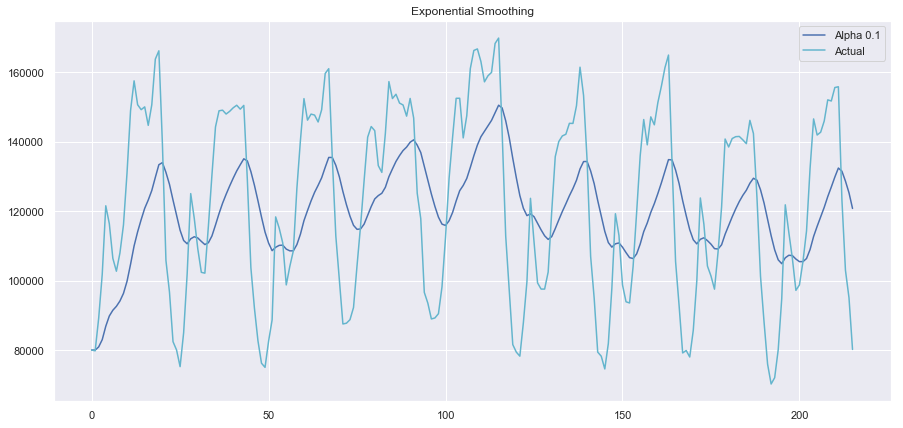

In [47]:
plt.figure(figsize=(15, 7))
plt.plot(result, label="Alpha 0.1")
plt.plot(ads.values, "c", label = "Actual")
plt.legend(loc="best")
plt.axis('tight')
plt.title("Exponential Smoothing")
plt.grid(True);

In [50]:
def suavizamiento_exponencial(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [52]:
def grafSuavExponencial(series, alphas):
   
    plt.figure(figsize=(15, 7))
    for alpha in alphas:
        plt.plot(suavizamiento_exponencial(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

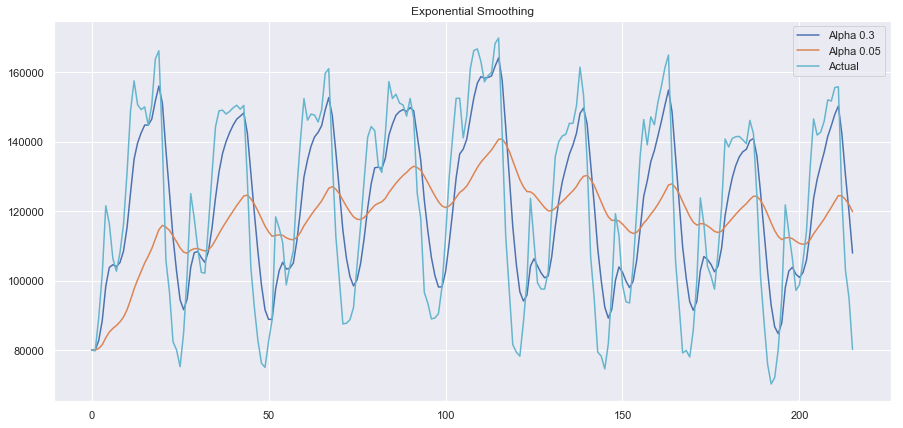

In [56]:
grafSuavExponencial(ads.Ads, [0.3, 0.05])

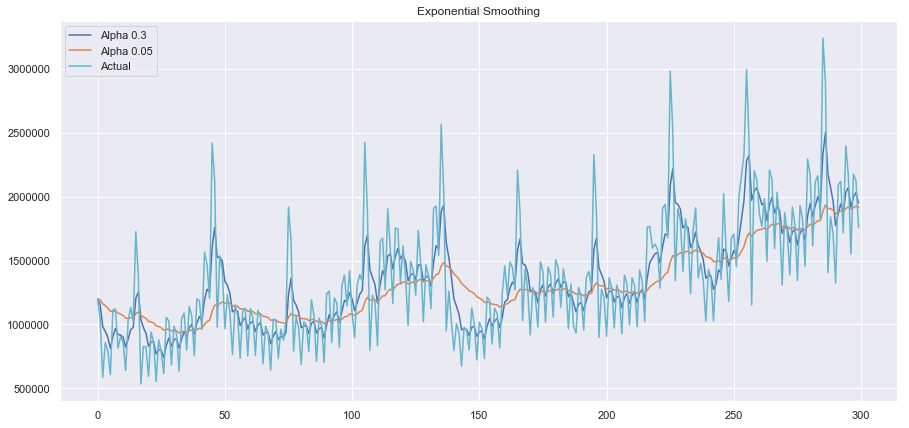

In [57]:
grafSuavExponencial(currency.GEMS_GEMS_SPENT, [0.3, 0.05])

### Suavizamiento exponencial doble

- $\ell_x = \alpha y_x + (1-\alpha)(\ell_{x-1} + b_{x-1}) \quad \quad \quad$        _Describe el intercepto_ 

- $b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1} \quad \quad \quad$ _Describe la tendencia_

- $\hat{y}_{x+1} = \ell_x + b_x \quad \quad \quad \quad \quad \quad \quad \quad \quad$ _Suma de los valores del modelo de la intersección y la tendencia_ 


### Suavizamiento exponencial triple (Holt-Winters)
La idea es agregar un tercer componente: estacionalidad

``statsmodels.tsa.holtwinters``

- $\ell_x = \alpha(y_x - s_{x-L}) + (1-\alpha)(\ell_{x-1} + b_{x-1})$

- $b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$

- $s_x = \gamma(y_x - \ell_x) + (1-\gamma)s_{x-L}$

- $\hat{y}_{x+m} = \ell_x + mb_x + s_{x-L+1+(m-1)modL}$

## 3. Pronósticos

### 3.1. Validación cruzada para series de tiempo

1. Entrenamos nuestro modelo en un pequeño segmento de la serie temporal desde el principio hasta $t$
2. Hacemos predicciones para los próximos pasos de $t + n$ y calculamos el error
3. Ampliamos nuestra muestra de entrenamiento a $t + n$
4. Hacemos predicciones desde $ t + n $ hasta $ t + 2 * n $
5. Continuamos moviendo nuestro segmento de prueba de la serie de tiempo hasta llegar a la última observación disponible

Como resultado, tenemos tantos pliegues como $ n $ encajarán entre la muestra de entrenamiento inicial y la última observación.

<img src="https://habrastorage.org/files/f5c/7cd/b39/f5c7cdb39ccd4ba68378ca232d20d864.png"/>

## 3.3. Modelos con enfoque econométrico

#### Estacionalidad


Un proceso es **estacionario** si no cambia sus propiedades estadísticas con el tiempo, es decir, su media, varianza y covarianza. (La constancia de la varianza se denomina **homocedasticidad**). La función de covarianza no depende del tiempo; solo debe depender de la distancia entre observaciones. 

**¿Por qué las siguientes series de tiempo son o no estacionarias?**

<img src="https://habrastorage.org/files/20c/9d8/a63/20c9d8a633ec436f91dccd4aedcc6940.png"/>


<img src="https://habrastorage.org/files/b88/eec/a67/b88eeca676d642449cab135273fd5a95.png"/>


<img src="https://habrastorage.org/files/2f6/1ee/cb2/2f61eecb20714352840748b826e38680.png"/>


### Estacionalidad, correlacion y autocorrelación parcial

**Prueba de raíz unitaria de Dickey-Fuller aumentada**

Si se tiene el proceso estocástico en tiempo discreto $\lbrace y_t; t=1,...,\infty \rbrace$ y suponemos que se puede escribir como un proceso autorregresivo de orden $p$:

$$y_t = a_1 y_{t-1} + a_2 y_{t-2} + ...+ a_p y_{t-p} + \epsilon_t$$

Entonces la **ecuación característica** del proceso es:

$$x^p - x^{p-1}a_1 - x^{p-2}a_2 - ...- a_p = 0.$$

Un proceso estocástico lineal tiene una **raíz unitaria** si el valor de la raíz de la ecuación característica del proceso es igual a 1, por lo tanto tal proceso es no estacionario.

La prueba de **Dickey-Fuller** aumentada se puede usar para probar una raíz unitaria en un proceso univariante en presencia de correlación serial.


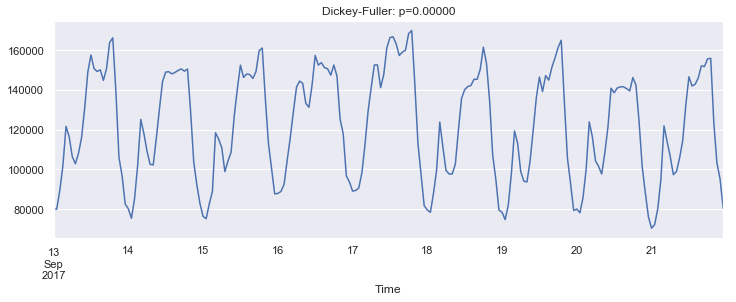

In [84]:
# graficar la serie de tiempo de ads e imprimir el p-valor del test de Dickey-Fuller
fig,ax = plt.subplots(figsize=(12,4))
ads.Ads.plot()
p_value = sm.tsa.stattools.adfuller(ads.Ads)[1]
ax.set_title('Dickey-Fuller: p={0:.5f}'.format(p_value))
plt.show()

- **Autocorrelación serial (ACF**): En el rezago k, ésta es la correlación entre los valores de la serie que están separados por k intervalos.

- **Autocorrelación parcial (PACF)**. En el rezago k, ésta es la correlación entre los valores de la serie que están separados por k intervalos, teniendo en cuenta los valores de los intervalos entre ellos.

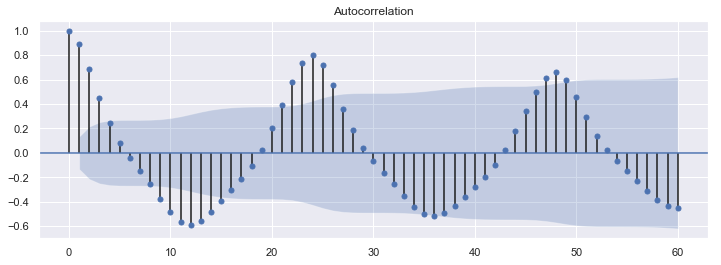

In [82]:
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize=(12,4))
plot_acf(ads.Ads, lags=60,ax=ax)
plt.show()

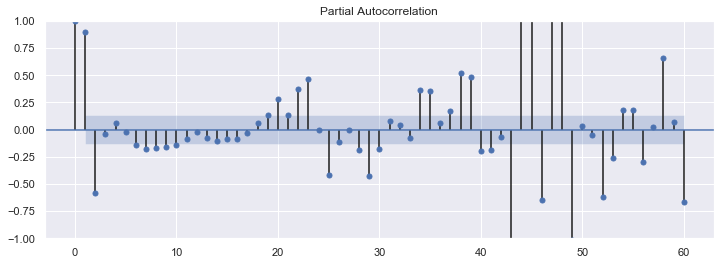

In [88]:
from statsmodels.graphics.tsaplots import plot_pacf

fig,ax = plt.subplots(figsize=(12,4))
plot_pacf(ads.Ads,alpha=.05 ,lags=60,ax=ax)
plt.ylim(-1,1)
plt.show()

In [89]:
def tsplot(y, lags=None, figsize=(12, 7)):

    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

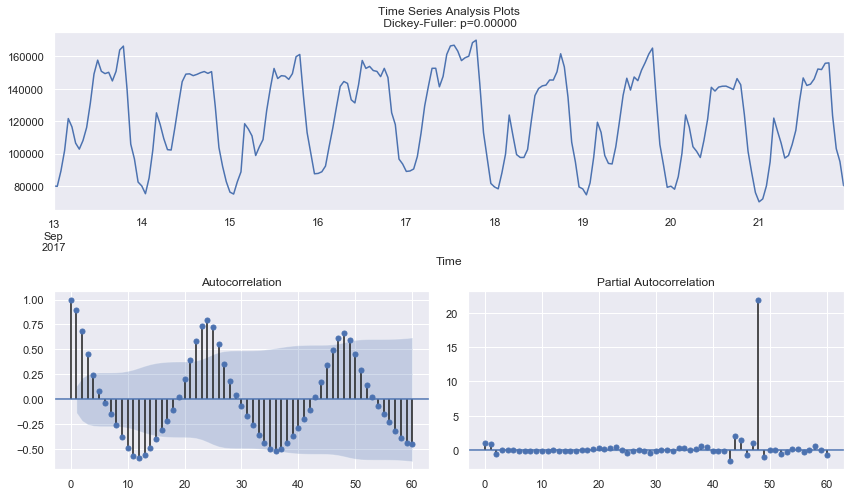

In [90]:
tsplot(ads.Ads, lags=60)

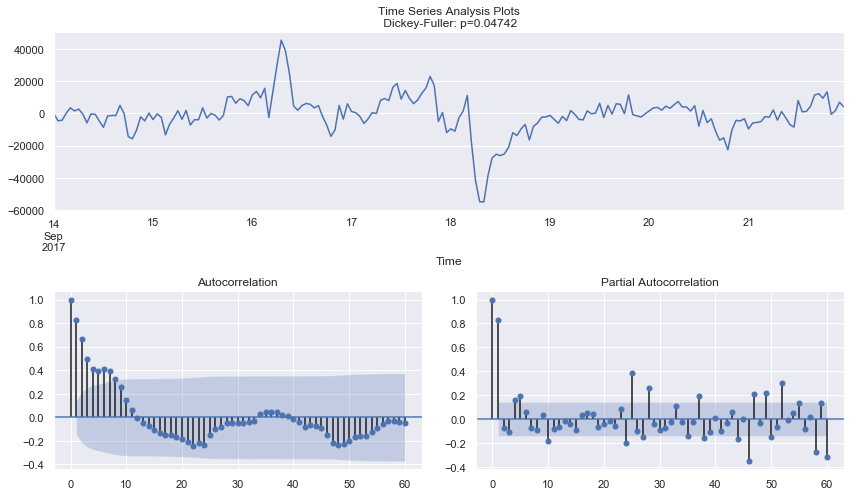

In [91]:
# estudiemos la serie de tiempo quitando el componente de periodiciad
ads_diff = ads.Ads - ads.Ads.shift(24)
tsplot(ads_diff[24:], lags=60)

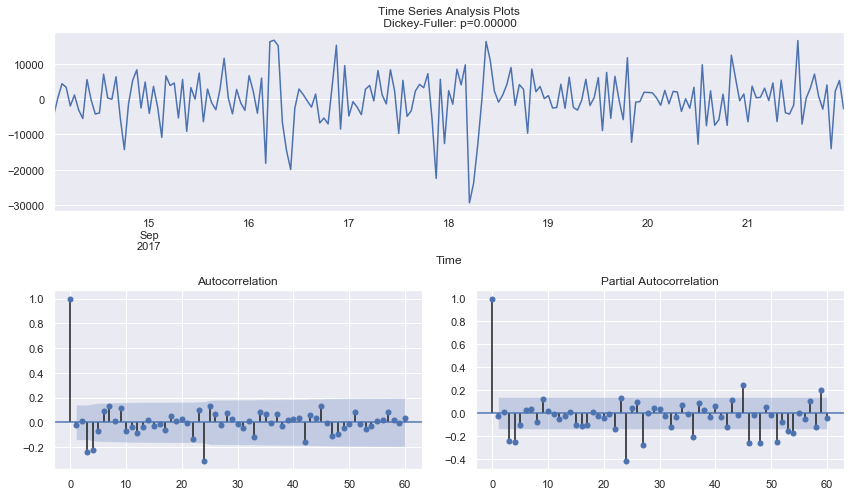

In [92]:
# estuddiemos la serie de tiempo de la primera diferencia
ads_diff = ads_diff - ads_diff.shift(1)
tsplot(ads_diff[24+1:], lags=60)

### Modelos ARIMA

Explicaremos este modelo construyendo letra por letra. $ SARIMA (p, d, q) (P, D, Q, s) $, modelo de media móvil de autorregresión estacional (Seasonal Autoregression Moving Average):

- $AR(p)$ - modelo de autorregresión, es decir, regresión de la serie temporal sobre sí misma. La suposición básica es que los valores de la serie actual dependen de sus valores anteriores con algún rezago (o varios rezagos). El rezago máximo en el modelo se conoce como $p$. Para determinar el $p$ inicial, debe mirar el gráfico PACF y encontrar el mayor rezago significativo después del cual **la mayoría** de los otros rezagos se vuelven insignificantes.
- $MA(q)$ - modelo de media móvil. Sin entrar en demasiados detalles, esto modela el error de la serie de tiempo, nuevamente asumiendo que el error actual depende del anterior con algún rezago, lo que se conoce como $q$. El valor inicial se puede encontrar en el gráfico ACF con la misma lógica que antes.

$$AR(p) + MA(q) = ARMA(p, q)$$

- $I(d)$ - orden de integración. Este es simplemente el número de diferencias no estacionales necesarias para que la serie sea estacionaria. En nuestro caso, es solo 1 porque usamos las primeras diferencias.

- $S(s)$ - esto es responsable de la estacionalidad e iguala la duración del período de la temporada de la serie

Con esto tenemos los parámetros: $(P, D, Q)$

In [93]:
# escogencia de algunos valores iniciales
ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 24 

# creamos una lista con todas las posibles combinaciones de parametros
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [94]:
def optimizeSARIMA(parameters_list, d, D, s):
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # agregamos un try porque alguna combinaciones de parametros pueden no converger
        try:
            model=sm.tsa.statespace.SARIMAX(ads.Ads, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # guardamos el mejor modelo, su AIC y sus parametros
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']

    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [95]:
%%time
tabla_resultados = optimizeSARIMA(parameters_list, d, D, s)


CPU times: user 1min 55s, sys: 1.22 s, total: 1min 56s
Wall time: 1min 2s


In [97]:
tabla_resultados.head()

,parameters,aic
0,"(2, 3, 1, 1)",3888.642174
1,"(3, 2, 1, 1)",3888.763568
2,"(4, 2, 1, 1)",3890.279740
3,"(3, 3, 1, 1)",3890.513196
4,"(2, 4, 1, 1)",3892.302849


In [99]:
# seleccionar los parametros que tienen un menos AIC
p, q, P, Q = tabla_resultados.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(ads.Ads, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                Ads   No. Observations:                  216
Model:             SARIMAX(2, 1, 3)x(1, 1, 1, 24)   Log Likelihood               -1936.321
Date:                            Thu, 29 Aug 2019   AIC                           3888.642
Time:                                    16:42:06   BIC                           3914.660
Sample:                                09-13-2017   HQIC                          3899.181
                                     - 09-21-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7913      0.270      2.928      0.003       0.262       1.321
ar.L2         -0.5503      0.306   

In [102]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [100]:
def plotSARIMA(series, model, n_steps):

    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

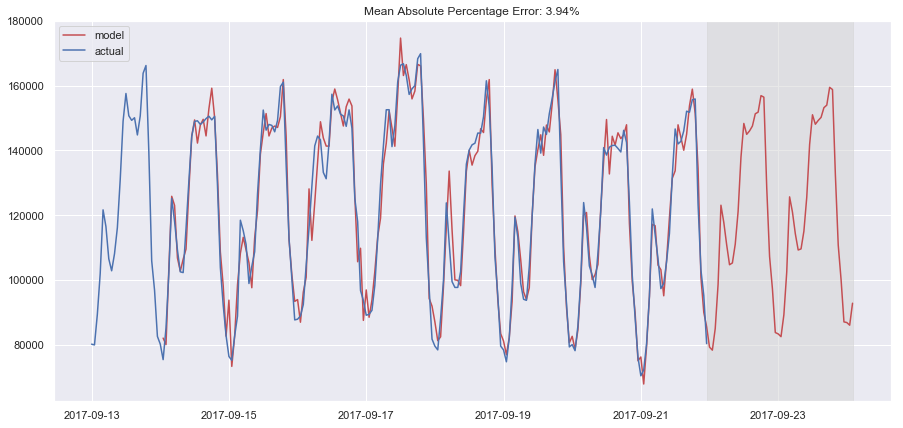

In [103]:
plotSARIMA(ads, best_model, 50)